# Board Game Text Analysis

In [1]:

#install.packages("tidytext")
#install.packages("textdata")
#install.packages("RSQLite")
#install.packages("fivethirtyeight")
#install.packages("forcats")
#install.packages("rsample")
#install.packages("rpart.plot")

library(broom, quietly = TRUE, warn.conflicts = FALSE)
library(forcats, quietly = TRUE, warn.conflicts = FALSE)
library(rpart.plot, quietly = TRUE, warn.conflicts = FALSE)
library(rsample, quietly = TRUE, warn.conflicts = FALSE)
library(tidyr, quietly = TRUE, warn.conflicts = FALSE)
library(fivethirtyeight, quietly = TRUE, warn.conflicts = FALSE)
library(RSQLite, quietly = TRUE, warn.conflicts = FALSE)
library(DBI, quietly = TRUE, warn.conflicts = FALSE)
library(ggplot2, quietly = TRUE, warn.conflicts = FALSE)
library(dplyr, quietly = TRUE, warn.conflicts = FALSE)
library(readr, quietly = TRUE, warn.conflicts = FALSE)
library(tidytext, quietly = TRUE, warn.conflicts = FALSE)
library(textdata, quietly = TRUE, warn.conflicts = FALSE)
library(stringr, quietly = TRUE, warn.conflicts = FALSE)
library(lubridate, quietly = TRUE, warn.conflicts = FALSE)
library(knitr, quietly = TRUE, warn.conflicts = FALSE)
library(hunspell, quietly = TRUE, warn.conflicts = FALSE)
library(rpart, quietly = TRUE, warn.conflicts = FALSE)
options(scipen = 99)


Warning message:
"package 'forcats' was built under R version 3.6.2"Warning message:
"package 'rpart.plot' was built under R version 3.6.2"Warning message:
"package 'rsample' was built under R version 3.6.2"Warning message:
"package 'fivethirtyeight' was built under R version 3.6.2"Warning message:
"package 'RSQLite' was built under R version 3.6.2"Warning message:
"package 'DBI' was built under R version 3.6.2"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'tidytext' was built under R version 3.6.2"Warning message:
"package 'textdata' was built under R version 3.6.2"Warning message:
"package 'hunspell' was built under R version 3.6.2"

In [2]:
bgames = dbConnect(RSQLite::SQLite(), "database.sqlite")

In [3]:
alltables = dbListTables(bgames)
p1 = dbGetQuery( bgames,'select * from BoardGames limit 1000' )

p1 <- p1 %>%  filter(game.id !=680)
p1 <- p1 %>% filter(game.id !=63)

In [4]:
my_hunspell_stem <- function(token) {
  stem_token <- hunspell_stem(token)[[1]]
  if (length(stem_token) == 0) return(token) else return(stem_token[1])
}
vec_hunspell_stem <- Vectorize(my_hunspell_stem, "token")


In [5]:
desc_tokens <- p1 %>% 
  mutate(details.description = str_replace_all(details.description, 
                                pattern=regex("(www|https?[^\\s]+)"), 
                                replacement = "")) %>% #rm urls
  mutate(details.description = str_replace_all(details.description,
                                pattern = "[[:digit:]]",
                                replacement = "")) %>% 
  unnest_tokens(tokens, details.description) %>% #tokenize
  mutate(tokens = vec_hunspell_stem(tokens)) %>% 
  filter(!(tokens %in% stop_words$word)) #rm stopwords

## Regression Tree of Words to Average Rating

In [6]:
desc_words <- desc_tokens %>%
    count(details.name,tokens,sort=TRUE)

total_words <- desc_words %>%
    group_by(details.name) %>%
    summarize(total=sum(n))

desc_summ <- left_join(desc_words,total_words)


desc_summ <- desc_summ %>%
    bind_tf_idf(tokens,details.name,n)



Joining, by = "details.name"


In [7]:
desc_cl <- desc_tokens

sparse_words <- desc_cl %>%
    count(details.name,tokens) %>%
    cast_sparse(details.name,tokens,n)

sparse_words = as.data.frame(as.matrix(sparse_words))


colnames(sparse_words) = make.names(colnames(sparse_words))

sort_val <- p1 %>%
    arrange(details.name) %>%
    select(stats.average)
dataset=cbind(sparse_words,sort_val)


desc_split <- dataset %>% initial_split()

train_data <- training(desc_split)
test_data <- testing(desc_split)



In [8]:
desc_part=rpart(stats.average~.,data=train_data)

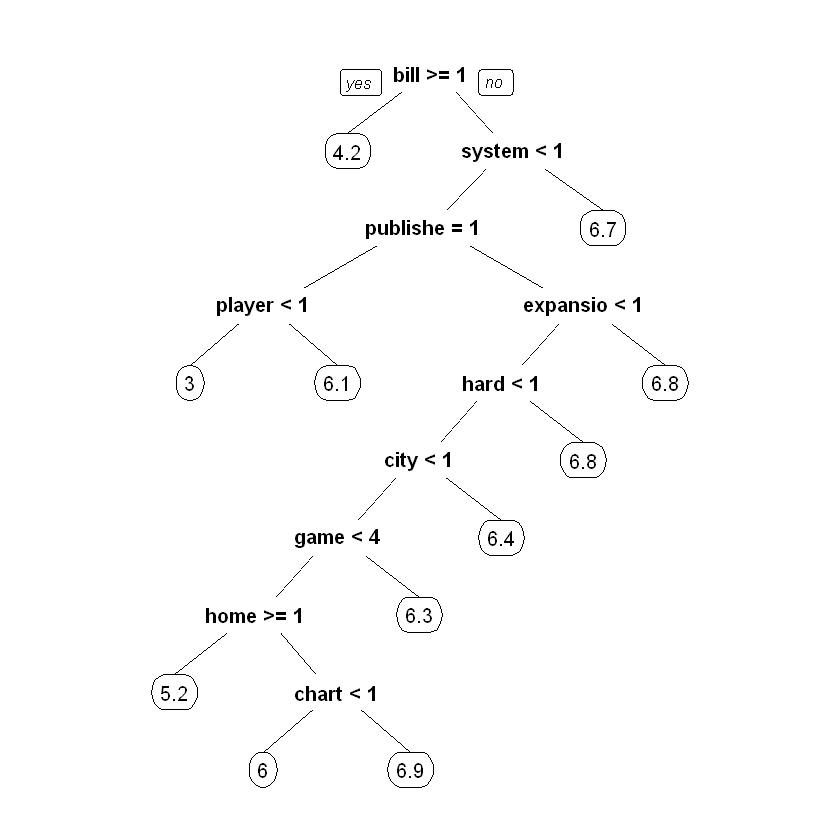

In [9]:
prp(desc_part)

In [10]:
test.pred.rtree <- predict(desc_part,test_data)
table(round(test_data$stats.average),round(test.pred.rtree))

RMSE.rtree <- sqrt(mean((round(test_data$stats.average)-round(test.pred.rtree))^2))

sprintf("RMSE is %f", RMSE.rtree) 

   
      3   4   5   6   7
  0   0   0   1   1   0
  4   1   0   0   7   0
  5   0   0   0  25   2
  6   1   1   1 110  17
  7   0   1   2  56  17
  8   0   0   0   3   3

[1] "RMSE is 0.985844"